In [1]:
%cd '/Users/abhilashdhal/Projects/'

/Users/abhilashdhal/Projects


In [2]:
import pandas as pd
from importlib import reload
import src.Engines.analysis_engine as analysis_engine
import src.Connectors.gcp_bigquery_utils as gcp_bigquery_utils
reload(analysis_engine)
reload(gcp_bigquery_utils)

<module 'src.Connectors.gcp_bigquery_utils' from '/Users/abhilashdhal/Projects/src/Connectors/gcp_bigquery_utils.py'>

## 1. Download Dataset from BigQuery for a given Primary Diagnosis By Primary Site and the Normal Tissue for the Primary site

In [3]:
project_id = 'rnaseqml'
dataset_id = 'rnaseqexpression'
table_id = 'expr_clustered_08082024'
bq_queries = gcp_bigquery_utils.BigQueryQueries(project_id=project_id, 
                                              dataset_id=dataset_id,
                                              table_id=table_id)



I0000 00:00:1725303525.127815  712075 config.cc:230] gRPC experiments enabled: call_status_override_on_cancellation, event_engine_dns, event_engine_listener, http2_stats_fix, monitoring_experiment, pick_first_new, trace_record_callops, work_serializer_clears_time_cache
I0000 00:00:1725303525.133415  712075 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


In [4]:
pr_site = 'Head and Neck'
pr_diag = 'Squamous cell carcinoma, NOS'
data_from_bq = bq_queries.get_df_for_pydeseq(primary_site=pr_site, primary_diagnosis=pr_diag)

I0000 00:00:1725303526.602047  712075 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


In [5]:
data_from_bq.head()

,case_id,primary_site,sample_type,tissue_type,primary_diagnosis,expr_unstr_count
0,5422a86d-f9ff-4fb6-873e-bf7cc3de50e5,Head and Neck,Primary Tumor,Tumor,"Squamous cell carcinoma, NOS","[1666, 0, 1310, 663, 367, 598, 10862, 1930, 20..."
1,2855bf40-e5e1-4519-b47a-327bfc275279,Head and Neck,Primary Tumor,Tumor,"Squamous cell carcinoma, NOS","[1597, 1, 1467, 544, 365, 345, 1172, 1256, 620..."
2,0fb3e5ff-54f0-43c5-9322-541bb7825e7f,Head and Neck,Primary Tumor,Tumor,"Squamous cell carcinoma, NOS","[977, 35, 2057, 539, 247, 1997, 6023, 2071, 12..."
3,3c5bc678-41e9-46b3-9686-5cd95659ab71,Head and Neck,Primary Tumor,Tumor,"Squamous cell carcinoma, NOS","[5433, 0, 2240, 2600, 3159, 402, 4090, 849, 22..."
4,50239d1d-b3a4-4240-ab83-b24ba67b1299,Head and Neck,Primary Tumor,Tumor,"Squamous cell carcinoma, NOS","[1211, 0, 2168, 325, 320, 114, 2900, 2571, 153..."


## 2. Data Preprocessing for PyDeSeq and GSEA

In [18]:
analysis_eng = analysis_engine.AnalysisEngine(data_from_bq, analysis_type='DE')
if not analysis_eng.check_tumor_normal_counts():
    raise ValueError("Tumor and Normal counts should be at least 10 each")
gene_ids_or_gene_cols_df = pd.read_csv('/Users/abhilashdhal/Projects/personal_docs/data/Transcriptomics/data/gene_annotation/gene_id_to_gene_name_mapping.csv')
gene_ids_or_gene_cols = list(gene_ids_or_gene_cols_df['gene_id'].to_numpy())

In [19]:
exp_df = analysis_eng.expand_data_from_bq(data_from_bq, gene_ids_or_gene_cols=gene_ids_or_gene_cols, analysis_type='DE')
metadata = analysis_eng.metadata_for_pydeseq(exp_df=exp_df)
counts_for_de = analysis_eng.counts_from_bq_df(exp_df, gene_ids_or_gene_cols)

## 3. Run DESeq2 for the given Primary Diagnosis By Primary Site and the Normal Tissue for the Primary site

In [20]:
res_pydeseq = analysis_eng.run_pydeseq(metadata=metadata, counts=counts_for_de)


03/09//2024 12:30:1725303653 AM - INFO - PyDeSeqWrapper.run_deseq: Running DESeq2 for groups: {'group1': 'Tumor', 'group2': 'Normal'}
03/09//2024 12:30:1725303653 AM - INFO - PyDeSeqWrapper.run_deseq: Running DESeq2  factor analysis with design factor: C and o
03/09//2024 12:30:1725303653 AM - INFO - PyDeSeqWrapper.run_deseq: Statistical analysis of Tumor vs Normal in {'group1': 'Tumor', 'group2': 'Normal'}


Fitting size factors...
... done in 0.42 seconds.

I0000 00:00:1725303657.111200  712075 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork
I0000 00:00:1725303657.131892  712075 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork
I0000 00:00:1725303657.135921  712075 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork
I0000 00:00:1725303657.144212  712075 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork
I0000 00:00:1725303657.150960  712075 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork
I0000 00:00:1725303657.160985  712075 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork
I0000 00:00:1725303657.170410  712075 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork
I0000 00:00:1725303657.190287  712075 work_stealing_thread_pool.cc:320] WorkStealingThreadPoolImpl::PrepareFork
I0000 00:00:1725303657.267184  712075 work_stealing_t

Log2 fold change & Wald test p-value: Condition Tumor vs Normal


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000258011.2,2232.991406,-1.416117,0.179004,-7.911108,2.551075e-15,1.366056e-13
ENSG00000186792.17,2.942486,-3.730918,0.730105,-5.110109,3.219736e-07,3.328443e-06
ENSG00000234551.2,1982.284385,0.129415,0.111797,1.157585,2.470336e-01,3.620486e-01
ENSG00000270818.1,518.247341,-0.349234,0.119929,-2.912014,3.591064e-03,1.210612e-02
ENSG00000008323.15,471.753783,1.068874,0.164111,6.513100,7.361526e-11,1.656502e-09
...,...,...,...,...,...,...
ENSG00000267077.1,0.360830,-0.410850,0.830193,-0.494886,6.206809e-01,NaN
ENSG00000109111.15,190.771788,-1.002799,0.133398,-7.517322,5.590952e-14,2.320717e-12
ENSG00000253088.1,0.000000,NaN,NaN,NaN,NaN,NaN
ENSG00000255401.1,2.472590,-1.105194,0.260670,-4.239828,2.236914e-05,1.465116e-04


In [21]:
res_pydeseq_with_gene_names = pd.merge(res_pydeseq, gene_ids_or_gene_cols_df, left_on='index', right_on='gene_id')

## 4. Run GSEA for the given Primary Diagnosis By Primary Site and the Normal Tissue for the Primary site using a gene set database

In [23]:
from gseapy.plot import gseaplot
import gseapy as gp
from gseapy import dotplot
gsea_options = gp.get_library_name()
print(gsea_options)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and

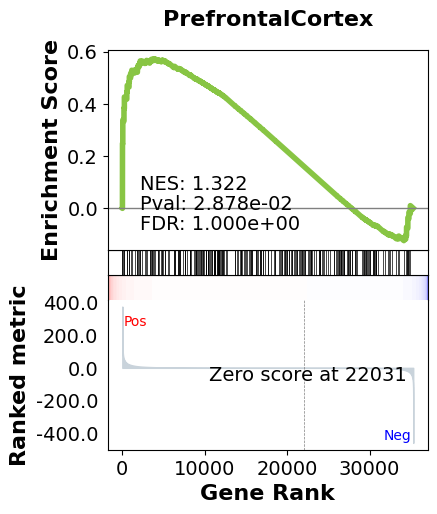

In [27]:
gene_set = 'Human_Gene_Atlas'
result, plot = analysis_eng.run_gsea(res_pydeseq_with_gene_names, gene_set)